# 基础配置

In [1]:
target_size = (224,224)
# 数据集
img_height, img_width = 224, 224  # 图片高宽
batch_size = 2  # 批量大小
epochs = 35  # 迭代次数
train_data_dir = '/content/drive/My Drive/covid/train'  # 训练集目录
validation_data_dir = '/content/drive/My Drive/covid/val'  # 验证集目录
OUT_CATEGORIES = 1  # 分类数
nb_train_samples = 1130  # 训练样本数
nb_validation_samples = 118  # 验证样本数
model_path = '/content/drive/My Drive/weights-improvement-09-0.88.hdf5'

# 新段落

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 配置优化器

In [2]:
# 自定义模型学习率
from keras import optimizers
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        print('被调用了')
        return optimizer.lr
    return lr
    
optimizer=optimizers.SGD(lr=0.0002, momentum=0.9)
lr_metric = get_lr_metric(optimizer)

Using TensorFlow backend.


# 训练

In [ ]:
from keras import optimizers
from keras import applications
from keras.applications.densenet import DenseNet201
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator


# 定义模型
base_model = DenseNet201(weights="imagenet", include_top=False,
                                input_shape=(img_width, img_height, 3))  # 预训练的VGG16网络，替换掉顶部网络
# print(base_model.summary())
top_model = Sequential()  # 自定义顶层网络
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  # 将预训练网络展平
top_model.add(Dense(img_height, activation='relu'))  # 全连接层，输入像素256
top_model.add(Dropout(0.5))  # Dropout概率0.6
top_model.add(Dense(OUT_CATEGORIES, activation='sigmoid'))  # 输出层，二分类
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))  # 新网络=预训练网络+自定义网络


model.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])  # 损失函数为二进制交叉熵，优化器为SGD

train_datagen = ImageDataGenerator(rescale=1. / 255,horizontal_flip=True)  # 训练数据预处理器，随机水平翻转

test_datagen = ImageDataGenerator(rescale=1. / 255)  # 测试数据预处理器
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=target_size,
                                                   batch_size=batch_size, class_mode='binary')  # 训练数据生成器
validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=target_size,
                                                        batch_size=batch_size, class_mode='binary',
                                                        shuffle=False)  # 验证数据生成器
print('测试集',len(validation_generator))
print('训练集',len(train_generator))
print('训练类别',train_generator.class_indices)

# 模型保留
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')

# checkpointer = ModelCheckpoint(filepath='dogcatmodel.h5', verbose=1, save_best_only=True)  # 保存最优模型
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', cooldown=0, min_lr=0)
# 训练&评估
history=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples / batch_size, epochs=epochs,
                    validation_data=validation_generator, validation_steps=nb_validation_samples / batch_size,
                    verbose=2, workers=12, callbacks=[checkpoint])  # 每轮一行输出结果，最大进程12

Found 1130 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
测试集 59
训练集 565
训练类别 {'CT_COVID': 0, 'CT_NonCOVID': 1}
Epoch 1/35
 - 197s - loss: 0.9313 - accuracy: 0.6796 - val_loss: 0.3915 - val_accuracy: 0.6780

Epoch 00001: val_accuracy improved from -inf to 0.67797, saving model to weights-improvement-01-0.68.h5
Epoch 2/35
 - 141s - loss: 0.3953 - accuracy: 0.8106 - val_loss: 0.0967 - val_accuracy: 0.7458

Epoch 00002: val_accuracy improved from 0.67797 to 0.74576, saving model to weights-improvement-02-0.75.h5
Epoch 3/35
 - 141s - loss: 0.2516 - accuracy: 0.9000 - val_loss: 0.2504 - val_accuracy: 0.7288

Epoch 00003: val_accuracy did not improve from 0.74576
Epoch 4/35
 - 141s - loss: 0.1721 - accuracy: 0.9381 - val_loss: 0.1498 - val_accuracy: 0.6695

Epoch 00004: val_accuracy did not improve from 0.74576
Epoch 5/35
 - 142s - loss: 0.1672 - accuracy: 0.9292 - val_loss: 0.0165 - val_accuracy: 0.7627

Epoch 00005: val_accuracy improved from 0.74576 to 0.76271, sa

# 模型加载

In [8]:
# 读入模型
from keras.models import load_model
model = load_model('/content/drive/My Drive/weights-improvement-18-0.83.h5')	

# 可视化训练过程

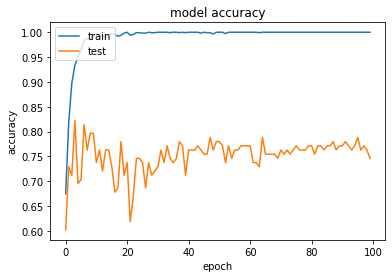

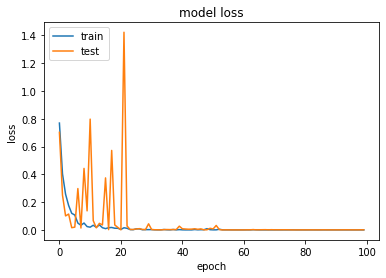

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# x=np.random.rand(10)
# y=np.random.rand(10)*10
 
# colors=np.random.rand(10)
# area=(30*np.random.rand(10))**2
# plt.scatter(x,y,s=200,c=colors,alpha=0.5,marker='x')
# plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 模型评估

In [9]:
# 模型评估
from keras.preprocessing.image import ImageDataGenerator
validation_data_dir = '/content/drive/My Drive/covid/test/'  # 测试集目录
test_datagen = ImageDataGenerator(rescale=1. / 255)  # 测试数据预处理器
validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=target_size,
                                                        batch_size=2, class_mode='binary',
                                                        shuffle=False) 
a = model.evaluate(validation_generator, steps=30)
print(model.metrics_names)
print(a)

Found 203 images belonging to 2 classes.
30/30 [==============================] - 39s 1s/step
['loss', 'accuracy']
[0.002249019453302026, 0.8999999761581421]


# 基础工具

In [ ]:
from PIL import Image
import numpy as np
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
# 预测函数
# 输入：model，图片，目标尺寸
# 输出：预测predict
def predict(model, img, target_size):

  if img.size != target_size:
    img = img.resize(target_size)
 
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  return (preds[0],x)

In [ ]:
# 数据增强

datagen = ImageDataGenerator(rotation_range=5,width_shift_range=0.02,height_shift_range=0.02,shear_range=0.02,horizontal_flip=True,vertical_flip=True
)

gen = datagen.flow_from_directory('/content/drive/My Drive/feiyan/train/c',target_size=target_size,batch_size=25,
                  save_to_dir='/content/yun5',#生成后的图像保存路径
                  save_prefix='xx',
                  save_format='jpg')
for i in range(15):
  gen.next()

# 基本使用

In [42]:
# from PIL import Image

# # 预测图片
from keras.preprocessing import image
imgfile='/content/drive/My Drive/covid/train/CT_COVID/2020.03.04.20031047-p12-81%1.png'
predict(imgfile)

1/1 [==============================] - 0s 115ms/step
[2.6316475e-05]
CT_COVID


In [41]:
from PIL import Image
from keras.applications.densenet import preprocess_input
# 预测函数
# 输入：model，图片，目标尺寸
# 输出：预测predict
def predict( imgfile):
  img =  image.load_img(imgfile, target_size=(224, 224, 3))
  img_data = image.img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data /= 255
  preds=model.predict(img_data, verbose=1)
  print(preds[0])
  cl=['CT_COVID','CT_NonCOVID']
  print(cl[1 if preds[0][0] >= 0.5 else 0])

1/1 [==============================] - 0s 107ms/step
[2.6316475e-05]
CT_COVID
原图


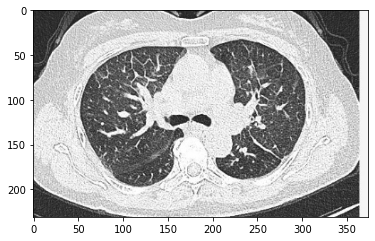

热力图


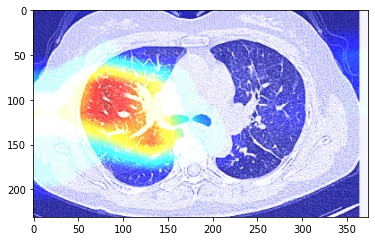

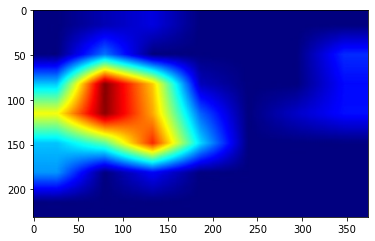

In [43]:
# 热力图显示

import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
import numpy as np
def load_img_preprocess(img_path, target_size):
    """
    加载图片并进行预处理
    :param img_path: 图片文件名
           target_size: 要加载图片的缩放大小
                        这是一个tuple元组类型
    :return: 预处理过的图像文件
    """
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img) # 转换成数组形式
    img = np.expand_dims(img, axis=0) # 为图片增加一维batchsize，直接设置为1

    img = preprocess_input(img) # 对图像进行标准化

    return img
def load_model_h5(model_file):
    """
    载入原始keras模型文件
    :param model_file: 模型文件，h5类型
    :return: 模型
    """
    return load_model(model_file,custom_objects={'lr': lr_metric})	
def gradient_compute(model, layername, img):
    """
    计算模型最后输出与你的layer的梯度
    并将每个特征图的梯度进行平均
    再将其与卷积层输出相乘
    :param model: 模型
    :param layername: 你想可视化热力的层名
    :param img: 预处理后的图像
    :return:
    卷积层与平均梯度相乘的输出值
    """
    preds = model.predict(img)
    idx = np.argmax(preds[0]) # 返回预测图片最大可能性的index索引

    output = model.output[:, idx] # 获取到我们对应索引的输出张量
    last_layer = model.get_layer(layername)

    grads = K.gradients(output, last_layer.output)[0]

    pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 对每张梯度特征图进行平均，
                                                 # 返回的是一个大小是通道维数的张量
    iterate = K.function([model.input], [pooled_grads, last_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([img])

    for i in range(pooled_grads.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    return conv_layer_output_value
def plot_heatmap(conv_layer_output_value, img_in_path, img_out_path):
    """
    绘制热力图
    :param conv_layer_output_value: 卷积层输出值
    :param img_in_path: 输入图像的路径
    :param img_out_path: 输出热力图的路径
    :return:
    """
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_in_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimopsed_img = heatmap * 0.9 + img

    cv2.imwrite(img_out_path, superimopsed_img)
    cv2.imwrite('./packagetest1.jpg', heatmap)
    # imgfile='/content/drive/My Drive/covid/train/CT_COVID/2020.03.04.20031047-p12-81%1.png'
    predict(img_path)
    print('原图')
    plt.imshow(cv2.cvtColor(cv2.imread(img_in_path), cv2.COLOR_BGR2RGB))
    plt.show()
    print('热力图')
    plt.imshow(cv2.cvtColor(cv2.imread(img_out_path), cv2.COLOR_BGR2RGB))
    plt.show()

    plt.imshow(cv2.cvtColor(cv2.imread('./packagetest1.jpg'), cv2.COLOR_BGR2RGB))
    plt.show()
img_path = r'/content/drive/My Drive/covid/train/CT_COVID/2020.03.04.20031047-p12-81%1.png'
layername = r'conv5_block32_2_conv'

img = load_img_preprocess(img_path, (224,224))
# model = load_model_h5(model_path)

conv_value = gradient_compute(model, layername, img)
plot_heatmap(conv_value, img_path, './packagetest.jpg')

In [ ]:
# 查看所有模型层
from keras.utils import plot_model
print(model.summary())